# Relative Permeability Upscaling: Capacity-Weighted Approach
**Author:** Ade Anggi Naluriawan Santoso | **Project:** Reservoir Simulation & History Matching

## Introduction
In this notebook, we will upscale relative permeability curves from a layered reservoir model. We assume the reservoir consists of distinct horizontal layers, each with different petrophysical properties (Permeability, Thickness) and different relative permeability characteristics (Corey exponents).

The goal is to generate a **single set of relative permeability curves (Krw, Kro)** that represents the flow behavior of the entire coarse grid block.

## Methodology
1.  **Load Data**: Import layer properties from CSV.
2.  **Fine-Scale Modeling**: Generate $k_r$ curves for each layer using Corey's approximation.
3.  **Upscaling**: Apply Capacity-Weighted Averaging (Arithmetic Mean weighted by $kh$).
4.  **Visualization**: Compare the fine-scale curves with the resulting coarse-scale curve.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Configuration for prettier plots
plt.style.use('ggplot')

## 1. Load Data
We will load the `fine_scale_layers.csv` file. This contains the rock properties for each layer in our reservoir section.

* **Permeability_mD ($k$)**: Absolute permeability.
* **Thickness_ft ($h$)**: Layer thickness.
* **Swi, Sor**: Irreducible water and residual oil saturation.
* **nw, no**: Corey exponents for water and oil.

In [2]:
# Load the dataset
df_layers = pd.read_csv('fine_scale_layers.csv')

# Display the layer properties
print("Reservoir Layer Properties:")
display(df_layers)

Reservoir Layer Properties:


,Layer_ID,Permeability_mD,Thickness_ft,Porosity,Swi,Sor,Krw_end,Kro_end,nw,no
0,1,500,10,0.25,0.20,0.25,0.6,0.9,2.0,2.0
1,2,50,15,0.18,0.30,0.35,0.4,0.7,3.0,3.0
2,3,1200,8,0.28,0.15,0.20,0.8,1.0,1.5,1.5
3,4,10,20,0.12,0.45,0.40,0.2,0.6,4.0,4.0
4,5,250,12,0.22,0.25,0.30,0.5,0.8,2.5,2.5


## 2. Define Corey Model
We need a function to calculate relative permeability at any given Water Saturation ($S_w$). We will use the standard **Corey Correlation**.

$$k_{rw} = k_{rw}^0 \left( S_w^* \right)^{n_w}$$
$$k_{ro} = k_{ro}^0 \left( 1 - S_w^* \right)^{n_o}$$

Where $S_w^*$ is the normalized water saturation:
$$S_w^* = \frac{S_w - S_{wi}}{1 - S_{wi} - S_{or}}$$

In [3]:
def corey_relperm(Sw, Swi, Sor, Krw_end, Kro_end, nw, no):
    """
    Calculates Krw and Kro based on Corey's approximation.
    
    Args:
        Sw (np.array): Water saturation array (0 to 1).
        Swi (float): Irreducible water saturation.
        Sor (float): Residual oil saturation.
        Krw_end (float): End-point relative permeability to water.
        Kro_end (float): End-point relative permeability to oil.
        nw (float): Corey exponent for water.
        no (float): Corey exponent for oil.
        
    Returns:
        tuple: (krw_array, kro_array)
    """
    # Normalized Saturation
    S_norm = (Sw - Swi) / (1 - Swi - Sor)
    
    # Clip values to stay within physical bounds [0, 1]
    S_norm = np.clip(S_norm, 0, 1)
    
    # Calculate Relative Permeabilities
    krw = Krw_end * (S_norm ** nw)
    kro = Kro_end * ((1 - S_norm) ** no)
    
    return krw, kro

## 3. Generate Fine-Scale Curves
We will define a global saturation array (from 0 to 1) and calculate the $k_r$ curves for every layer individually.

We calculate the **Flow Capacity ($kh$)** for each layer, as this will be our weighting factor.
$$Capacity_i = k_i \times h_i$$

In [4]:
# Create a global saturation array (0 to 1 with 100 steps)
Sw_array = np.linspace(0, 1, 100)

# Initialize lists to store curves and capacities
layer_krw = []
layer_kro = []
layer_capacities = []

# Iterate through each layer in the dataframe
for index, row in df_layers.iterrows():
    # Calculate flow capacity (k * h)
    kh = row['Permeability_mD'] * row['Thickness_ft']
    layer_capacities.append(kh)
    
    # Generate curves for this layer
    krw, kro = corey_relperm(
        Sw_array, 
        row['Swi'], row['Sor'], 
        row['Krw_end'], row['Kro_end'], 
        row['nw'], row['no']
    )
    
    layer_krw.append(krw)
    layer_kro.append(kro)

# Convert lists to numpy arrays for easier vectorized math
# Shape: (Number of Layers, 100 saturation points)
layer_krw = np.array(layer_krw)
layer_kro = np.array(layer_kro)
layer_capacities = np.array(layer_capacities).reshape(-1, 1) # Reshape for broadcasting

print(f"Calculated curves for {len(df_layers)} layers.")
print(f"Total Flow Capacity (Sigma kh): {np.sum(layer_capacities):.2f} mD.ft")

Calculated curves for 5 layers.
Total Flow Capacity (Sigma kh): 18550.00 mD.ft


## 4. Perform Upscaling (Capacity-Weighted Average)

The upscaled relative permeability is the **weighted average** of the individual layer relative permeabilities. The weight is the flow capacity ($kh$) of the layer.

High permeability layers contribute *more* to the effective relative permeability because fluid flows through them more easily.

$$K_{r,eff} = \frac{\sum (kh_i \times K_{r,i})}{\sum kh_i}$$

In [5]:
# Sum of capacities (denominator)
total_capacity = np.sum(layer_capacities)

# Weighted sum of Krw and Kro (numerator)
# We use np.sum with axis=0 to sum across layers for each saturation step
weighted_krw_sum = np.sum(layer_krw * layer_capacities, axis=0)
weighted_kro_sum = np.sum(layer_kro * layer_capacities, axis=0)

# Calculate Effective Curves
Krw_upscaled = weighted_krw_sum / total_capacity
Kro_upscaled = weighted_kro_sum / total_capacity

print("Upscaling complete.")

Upscaling complete.


## 5. Visualization
Let's visualize the results. We will plot:
1.  **Grey dashed lines**: The individual fine-scale curves for every layer.
2.  **Bold Red/Blue lines**: The resulting Upscaled (Effective) curves.

Notice how the upscaled curve tends to follow the "best" layers (highest permeability) because they dominate the flow.

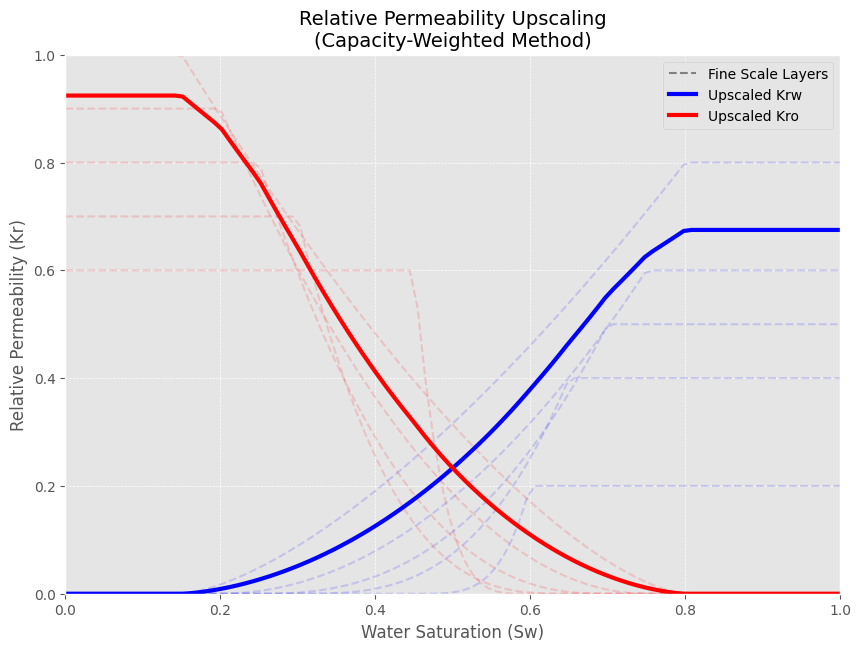

In [6]:
plt.figure(figsize=(10, 7))

# Plot individual layers (Fine Scale)
for i in range(len(df_layers)):
    plt.plot(Sw_array, layer_krw[i], color='blue', alpha=0.15, linestyle='--')
    plt.plot(Sw_array, layer_kro[i], color='red', alpha=0.15, linestyle='--')

# Plot dummy lines for legend to represent fine scale
plt.plot([], [], color='gray', linestyle='--', label='Fine Scale Layers')

# Plot Upscaled Curves (Coarse Scale)
plt.plot(Sw_array, Krw_upscaled, color='blue', linewidth=3, label='Upscaled Krw')
plt.plot(Sw_array, Kro_upscaled, color='red', linewidth=3, label='Upscaled Kro')

# Formatting
plt.title('Relative Permeability Upscaling\n(Capacity-Weighted Method)', fontsize=14)
plt.xlabel('Water Saturation (Sw)', fontsize=12)
plt.ylabel('Relative Permeability (Kr)', fontsize=12)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

## Expansion 1: Vertical Permeability Upscaling (Harmonic Average)

While the previous exercise calculated $K_{r,eff}$ for flow *parallel* to the layers (Horizontal Flow), flow *perpendicular* to the layers (Vertical Flow) encounters resistance in series.

For vertical flow, the effective permeability is dominated by the "tightest" (lowest permeability) layer. The correct upscaling method is the **Harmonic Average** weighted by thickness ($h$).

$$K_{r,z,coarse} = \frac{\sum h_i}{\sum \left( \frac{h_i}{k_i \cdot k_{r,i}(S_w)} \right)} \times \frac{1}{K_{z,avg}}$$

Where $K_{z,avg}$ is the harmonic average of absolute permeability.

Absolute Horizontal Perm (Arithmetic): 285.38 mD
Absolute Vertical Perm (Harmonic):   27.37 mD


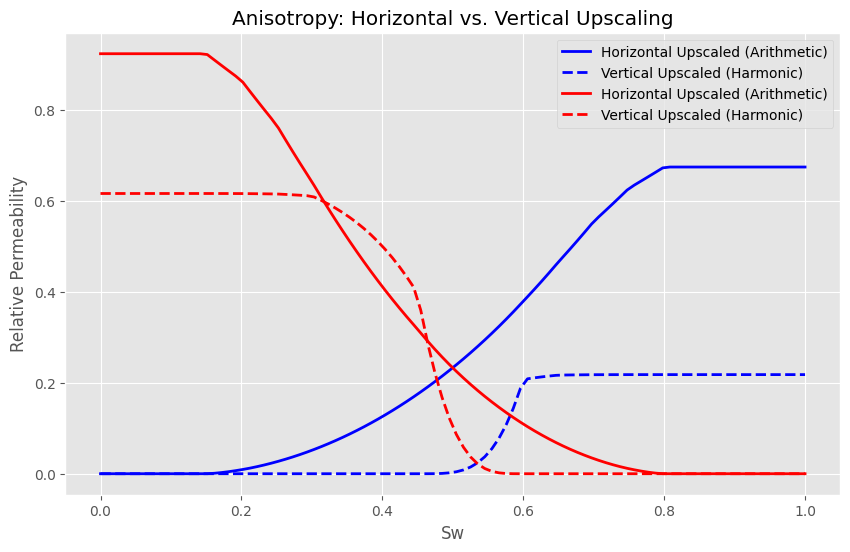

In [7]:
# 1. Calculate Absolute Vertical Permeability (Harmonic Mean)
total_thickness = df_layers['Thickness_ft'].sum()
sum_h_over_k = np.sum(df_layers['Thickness_ft'] / df_layers['Permeability_mD'])
K_z_avg = total_thickness / sum_h_over_k

print(f"Absolute Horizontal Perm (Arithmetic): {np.sum(layer_capacities)/total_thickness:.2f} mD")
print(f"Absolute Vertical Perm (Harmonic):   {K_z_avg:.2f} mD")

# 2. Calculate Vertical Relative Permeability Curves
# Avoid division by zero by adding a tiny epsilon
epsilon = 1e-9 
layer_krw_safe = np.maximum(layer_krw, epsilon)
layer_kro_safe = np.maximum(layer_kro, epsilon)

# Harmonic Averaging Logic for Relative Perm
# Denominator: Sum of (h_i / (k_i * kr_i))
denom_krw = np.sum((df_layers['Thickness_ft'].values[:, None]) / 
                   (df_layers['Permeability_mD'].values[:, None] * layer_krw_safe), axis=0)

denom_kro = np.sum((df_layers['Thickness_ft'].values[:, None]) / 
                   (df_layers['Permeability_mD'].values[:, None] * layer_kro_safe), axis=0)

# Final Kr_z Calculation
Krz_w_upscaled = (total_thickness / denom_krw) / K_z_avg
Krz_o_upscaled = (total_thickness / denom_kro) / K_z_avg

# Plot Comparison
plt.figure(figsize=(10, 6))
plt.plot(Sw_array, Krw_upscaled, 'b-', linewidth=2, label='Horizontal Upscaled (Arithmetic)')
plt.plot(Sw_array, Krz_w_upscaled, 'b--', linewidth=2, label='Vertical Upscaled (Harmonic)')
plt.plot(Sw_array, Kro_upscaled, 'r-', linewidth=2, label='Horizontal Upscaled (Arithmetic)')
plt.plot(Sw_array, Krz_o_upscaled, 'r--', linewidth=2, label='Vertical Upscaled (Harmonic)')
plt.title("Anisotropy: Horizontal vs. Vertical Upscaling")
plt.xlabel("Sw")
plt.ylabel("Relative Permeability")
plt.legend()
plt.show()

## Expansion 2: Parameter Extraction (Curve Fitting)

The upscaled curve is a numerical array. To use this in a simulator, we often need to regress it back to a standard equation. We will use `scipy.optimize.curve_fit` to find the **effective Corey exponents** that best describe our new coarse block.

Note: Upscaling heterogeneous layers often results in "smeared" curves that may not fit the Corey model perfectly. This mismatch is a measure of heterogeneity.

The effective Corey exponent for Water (nw) is: 1.758


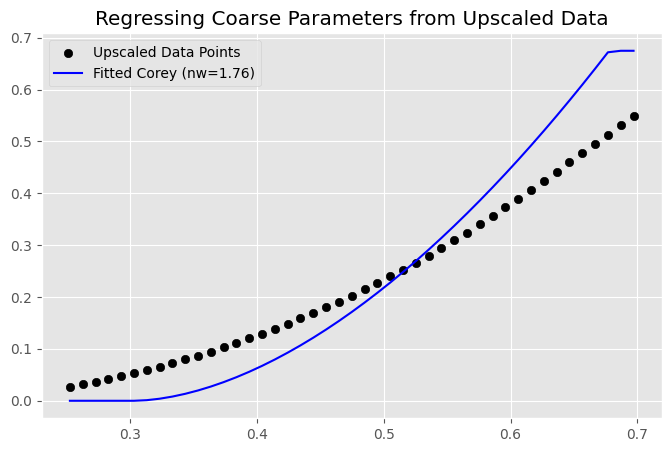

In [8]:
from scipy.optimize import curve_fit

def corey_w_func(Sw, nw_eff):
    # Fixed endpoints based on volume-weighted averages (simplification) or user definition
    Swi_avg = np.average(df_layers['Swi'], weights=df_layers['Thickness_ft'])
    Sor_avg = np.average(df_layers['Sor'], weights=df_layers['Thickness_ft'])
    Krw_end_avg = np.max(Krw_upscaled) # Take max of upscaled
    
    S_norm = (Sw - Swi_avg) / (1 - Swi_avg - Sor_avg)
    S_norm = np.clip(S_norm, 0, 1)
    return Krw_end_avg * (S_norm ** nw_eff)

# Filter valid data range for fitting (where Kr > 0)
valid_idx = (Sw_array > 0.25) & (Sw_array < 0.7) # Approximate range
x_data = Sw_array[valid_idx]
y_data = Krw_upscaled[valid_idx]

# Perform Fit
popt, pcov = curve_fit(corey_w_func, x_data, y_data, p0=[2.0])
nw_effective = popt[0]

print(f"The effective Corey exponent for Water (nw) is: {nw_effective:.3f}")

# Visualize Fit
plt.figure(figsize=(8,5))
plt.scatter(x_data, y_data, color='black', label='Upscaled Data Points')
plt.plot(x_data, corey_w_func(x_data, nw_effective), 'b-', label=f'Fitted Corey (nw={nw_effective:.2f})')
plt.legend()
plt.title("Regressing Coarse Parameters from Upscaled Data")
plt.show()

## Expansion 3: Fractional Flow Analysis

Relative permeability upscaling is critical for predicting **Water Breakthrough Time**. We calculate the Fractional Flow of water ($f_w$) for the coarse block:

$$f_w = \frac{1}{1 + \frac{k_{ro}}{k_{rw}} \frac{\mu_w}{\mu_o}}$$

By plotting $f_w$ vs $S_w$, we can observe how heterogeneity changes the displacement efficiency.

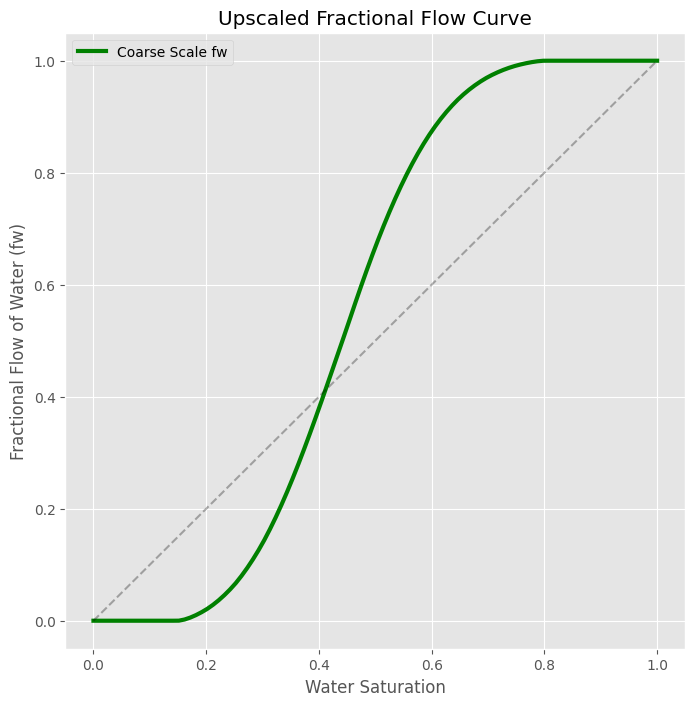

In [9]:
# Assumed Viscosities
mu_w = 1.0  # cP
mu_o = 2.0  # cP

# Calculate fw for Coarse Scale
# Avoid div by zero
with np.errstate(divide='ignore', invalid='ignore'):
    fw_coarse = 1 / (1 + (Kro_upscaled / (Krw_upscaled + 1e-9)) * (mu_w / mu_o))

# Plot
plt.figure(figsize=(8, 8))
plt.plot(Sw_array, fw_coarse, 'g-', linewidth=3, label='Coarse Scale fw')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.3) # 45 degree line
plt.xlabel("Water Saturation")
plt.ylabel("Fractional Flow of Water (fw)")
plt.title("Upscaled Fractional Flow Curve")
plt.legend()
plt.grid(True)
plt.show()

# 6. Discussion & Analysis of Results

This section provides a detailed interpretation of the upscaling exercise, analyzing the effects of heterogeneity on coarse-scale flow behavior based on the generated plots.

### 6.1 Capacity-Weighted Upscaling (Horizontal Flow)
**Observation:**
In the **Capacity-Weighted Method** plot, the upscaled curves (bold Blue/Red lines) do not represent a simple geometric average of the fine-scale curves (grey dashed lines). Instead, they are heavily skewed toward the upper bound of the fine-scale cluster.

**Physical Interpretation:**
* **High-Permeability Dominance:** This behavior confirms that in a parallel flow system (flow *along* the layers), the effective relative permeability is dominated by the high-permeability layers. These layers have the highest flow capacity ($kh$), effectively acting as "thief zones" that carry the majority of the fluid.
* **Smoothing Effect:** The averaging process smooths out the sharp variations found in individual rock types. The coarse block behaves as a composite material with a more generalized flow character than any single geologic layer.

### 6.2 Anisotropy: Horizontal vs. Vertical Flow
**Observation:**
The **Anisotropy** plot reveals a drastic discrepancy between Horizontal upscaling (Solid lines, Arithmetic averaging) and Vertical upscaling (Dashed lines, Harmonic averaging).

**Physical Interpretation:**
* **The "Baffle" Effect:** The vertical effective permeability is significantly suppressed. This is because vertical flow is a "series" circuit; fluids are forced to pass through *every* layer, including the tightest (lowest permeability) rocks.
* **Harmonic Averaging:** The harmonic average is mathematically dominated by the minimum values. Even a thin, low-permeability layer acts as a bottleneck, severely reducing the vertical flow capacity ($K_{rv} \ll K_{rh}$).
* **Simulation Impact:** Neglecting this anisotropy in a reservoir simulator would lead to overly optimistic predictions of vertical sweep efficiency and gravity drainage.

### 6.3 Regression & Parameter Extraction
**Observation:**
In the **Regression** plot, we attempted to fit a single Corey curve ($n_w = 1.76$) to the upscaled data points (black dots). Note the deviation at low water saturations ($S_w < 0.35$), where the data points show non-zero flow while the fitted curve is near zero.

**Physical Interpretation:**
* **Smearing / Early Breakthrough:** The upscaled data points exhibit a "tail" at low saturations. This represents the physical reality that high-permeability layers begin conducting water *before* the average saturation of the entire coarse block rises significantly.
* **Loss of Fidelity:** By forcing the heterogeneous data into a single homogeneous Corey equation, we lose the detail of this early breakthrough. The fitted model slightly underestimates the risk of early water production by suppressing this "tail."

### 6.4 Fractional Flow Analysis
**Observation:**
The **Fractional Flow ($f_w$)** curve shows a stretched "S-shape" compared to what is typically seen in homogeneous sands.

**Physical Interpretation:**
* **Pseudo-Dispersion:** The layering creates a phenomenon known as "Numerical Dispersion" or "Pseudo-Dispersion." Because different layers allow fluids to travel at different speeds, the macroscopic displacement front is spread out.
* **Shock Front:** The resulting fractional flow curve implies a more gradual transition from oil to water production, rather than a sharp, piston-like displacement. This confirms that heterogeneity inherently reduces the displacement efficiency of the reservoir system.